In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected = True)
import plotly.figure_factory as ff
import fasttext
import bz2
import csv
from sklearn.metrics import roc_auc_score
import os

In [2]:
hair_dryer=pd.read_csv('hair_dryer.tsv', sep='\t',header=0,index_col='review_id')
microwave=pd.read_csv('microwave.tsv', sep='\t',header=0,index_col='review_id')
pacifier=pd.read_csv('pacifier.tsv', sep='\t',header=0,index_col='review_id')
col_names = ["customer_id","product_parent","star_rating","helpful_votes","vine","verified_purchase","total_votes",
             "review_headline","review_body","review_date"]
data_names = ["hair_dryer","microwave","pacifier"]
data_total = [hair_dryer,microwave,pacifier]
for i,name in enumerate(data_names):
    data_total[i] = data_total[i][col_names]

In [252]:
def vis_data(data,name=None):
    sns.set(rc={'figure.facecolor':'white'})
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'

    print("there is any null data or not:",data.isnull().any().any())
    print("adding a length column for analyzing the length of the reviews")
    data['review_body_length'] = data['review_body'].apply(len)
    # 这里会出错，所以没有考虑评论的标题
#     data['review_headline_length'] = data['review_headline'].apply(len)
#     data.groupby('length').describe().sample(10)
    print(data.groupby('star_rating').describe())
    ratings = data["star_rating"].value_counts()
    label_rating = ratings.index
    size_rating = ratings.values
    
    colors = ['pink', 'lightblue', 'aqua', 'gold', 'crimson']

    rating_piechart = go.Pie(labels = label_rating,
                         values = size_rating,
                         marker = dict(colors = colors),
                         name = f'{name}', hole = 0.3)

    df = [rating_piechart]

    layout = go.Layout(title = f'Distribution of Ratings for {name}',plot_bgcolor='#ffffff',paper_bgcolor='#ffffff')

    fig = go.Figure(data = df,
                 layout = layout)

    py.iplot(fig)
    
    ####################################################条形图
    color = plt.cm.copper(np.linspace(0, 1, 20))
    data['product_parent'].value_counts()[:20].plot.bar(color = color, figsize = (15, 9),colormap="#ffffff")
    plt.title(f'Distribution of {name} in kinds(1-20st)', fontsize = 20)
    plt.xlabel(f'{hair_dryer} kind')
    plt.ylabel('count')
    plt.show()
    
    #####################################################饼形
    verified_purchase = data['verified_purchase'].value_counts()

    label_verified_purchase = verified_purchase.index
    size_verified_purchase = verified_purchase.values

    colors = ['yellow', 'lightgreen']

    feedback_piechart = go.Pie(labels = label_verified_purchase,
                         values = size_verified_purchase,
                         marker = dict(colors = colors),
                         name = f'{name}', hole = 0.3)

    df2 = [feedback_piechart]

    layout = go.Layout(
           title = f'Distribution of verified_purchase for {name}',plot_bgcolor='#ffffff',paper_bgcolor='#ffffff')

    fig = go.Figure(data = df2,
                 layout = layout)

    py.iplot(fig)
    
    
    # 统计图
    sns.set_style("whitegrid")
    data['review_body_length'].value_counts().plot.hist(color = 'skyblue', figsize = (15, 5), bins = 50)
    plt.title('Distribution of Length in Reviews')
    plt.xlabel('lengths')
    plt.ylabel('count')
    plt.show()
    
#     print("Let's Check some of the reviews according to thier lengths")
#     print(data[data['review_body_length'] == 1]['review_body'].iloc[0])
#     print(data[data['review_body_length'] == 21]['review_body'].iloc[0])
#     print(data[data['review_body_length'] == 50]['review_body'].iloc[0])
#     print(data[data['review_body_length'] == 150]['review_body'].iloc[0])
    
    ### 绘制一个奇怪的图性
    plt.rcParams['figure.figsize'] = (15, 9)
    plt.style.use('fivethirtyeight')
    
    namess = data['product_parent'].value_counts()[:20].index.tolist()
    p_data = data.loc[data["product_parent"].isin(namess)]
    sns.set(rc={'figure.facecolor':'white'})
    sns.set_style("whitegrid")
    sns.boxenplot(p_data['product_parent'], p_data['star_rating'], palette = 'spring')
    plt.title("product_kind vs star_ratings")
    plt.xticks(rotation = 90)
    plt.show()
    
    
    # 绘制散点图
    plt.rcParams['figure.figsize'] = (15, 9)
    plt.style.use('fivethirtyeight')
    sns.set_style("whitegrid")
    sns.swarmplot(p_data['product_parent'], data['review_body_length'], palette = 'deep')
    plt.title("product kind vs Length of Ratings")
    plt.xticks(rotation = 90)
    plt.show()
    
    ## 绘制奇怪图二
    import warnings
    warnings.filterwarnings('ignore')

    plt.rcParams['figure.figsize'] = (12, 7)
    plt.style.use('fivethirtyeight')
    
    sns.set_style("whitegrid")
    sns.violinplot(data['verified_purchase'], data['star_rating'], palette = 'cool')
    plt.title("verified_purchase wise Mean Ratings")
    plt.show()
    
    ### 绘制箱线图
    warnings.filterwarnings('ignore')

    plt.rcParams['figure.figsize'] = (12, 7)
    plt.style.use('fivethirtyeight')
    sns.set_style("whitegrid")
    sns.boxplot(data['star_rating'], data['review_body_length'], palette = 'Blues')
    plt.title("review_body_length vs star_rating")
    plt.show()
    
    from sklearn.feature_extraction.text import CountVectorizer
    
    # 进行词频的统计
    cv = CountVectorizer(stop_words = 'english')
    words = cv.fit_transform(data.review_body)
    sum_words = words.sum(axis=0)


    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

    plt.style.use('fivethirtyeight')
    color = plt.cm.ocean(np.linspace(0, 1, 20))
    sns.set_style("whitegrid")
    frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
    plt.title("Most Frequently Occuring Words - Top 20")
    plt.show()
    
    
    ## 词云图
    from wordcloud import WordCloud

    wordcloud = WordCloud(background_color = 'lightcyan', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.title("Vocabulary from Reviews", fontsize = 20)
    plt.show()

    namesss = data['product_parent'].value_counts()[:5].index.tolist()
    pp_data = data.loc[data["product_parent"].isin(namesss)]
    print(frequency.head(20))
    trace = go.Scatter3d(
    x = data['review_body_length'],
    y = data['star_rating'],
    z = pp_data['product_parent'],
    mode='markers',
    name = name,
    marker=dict(
        size=10,
        color = data['star_rating'],
        colorscale = 'Viridis',))
    df = [trace]
    layout = go.Layout(
        title = 'Length vs Frequency word vs Ratings',plot_bgcolor='#ffffff',paper_bgcolor='#ffffff',
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0  ) )
    fig = go.Figure(data = df, layout = layout)
    iplot(fig)

there is any null data or not: False
adding a length column for analyzing the length of the reviews
            customer_id                                                     \
                  count          mean           std       min          25%   
star_rating                                                                  
1                1032.0  2.988996e+07  1.507119e+07   32192.0  16347130.25   
2                 639.0  3.013211e+07  1.513969e+07  139704.0  15752999.50   
3                 999.0  2.895417e+07  1.531671e+07   92698.0  15309833.00   
4                2095.0  2.802716e+07  1.519079e+07   58338.0  14803166.00   
5                6703.0  2.761288e+07  1.523959e+07   12464.0  14576620.00   

                                                product_parent                \
                    50%         75%         max          count          mean   
star_rating                                                                    
1            29290557.0  43958092.5

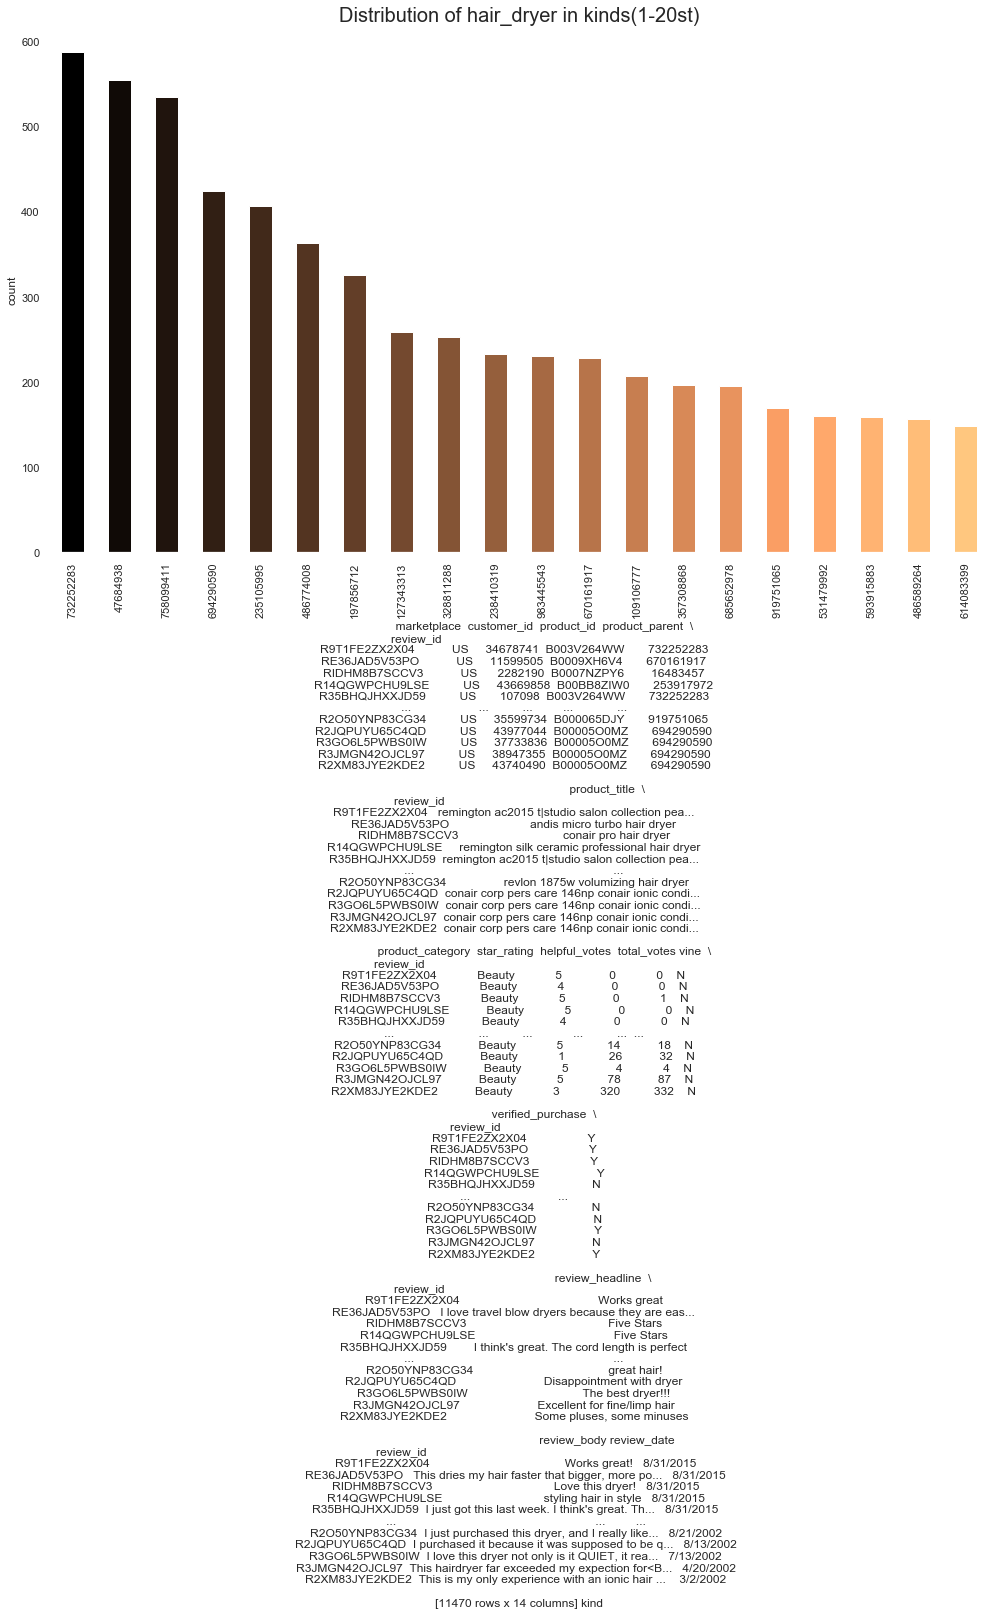

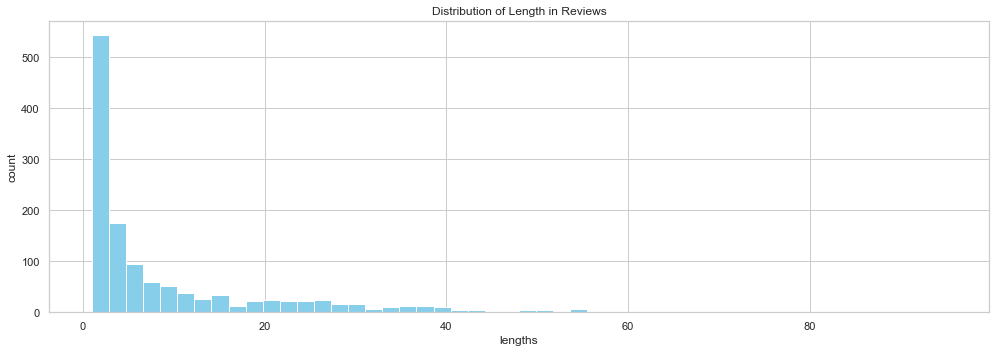

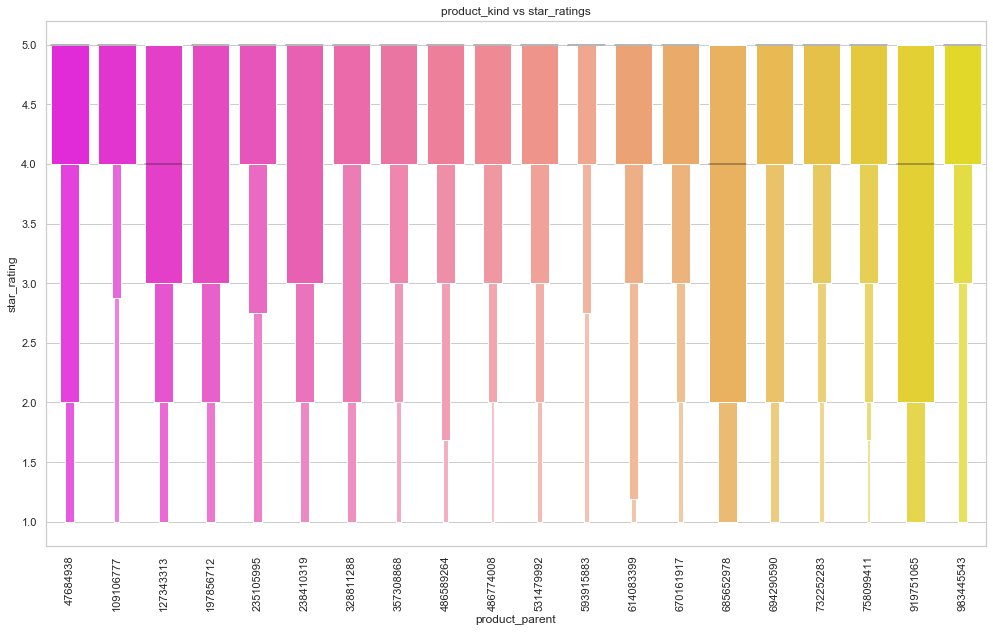

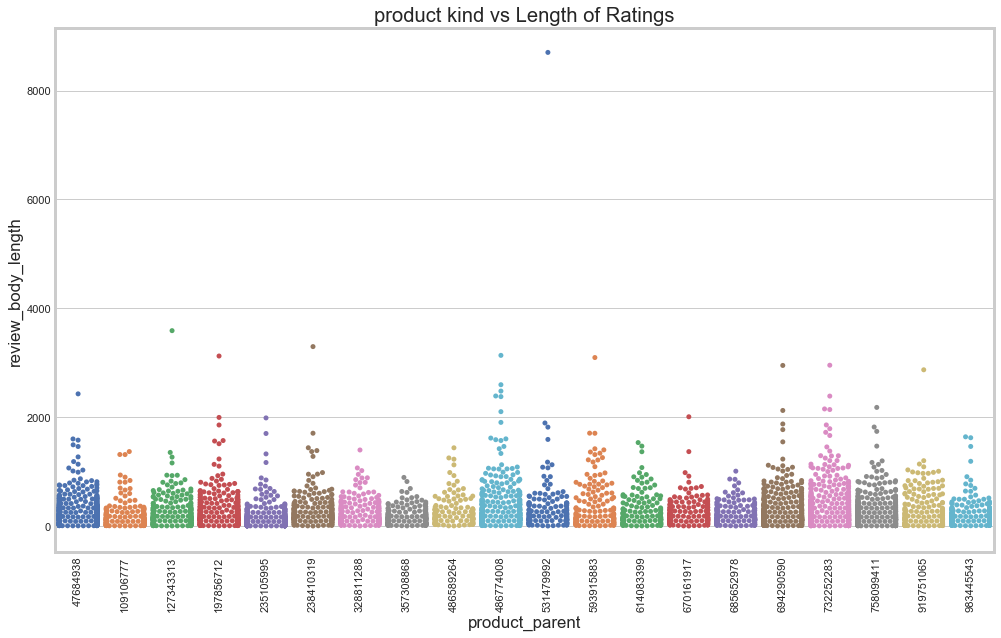

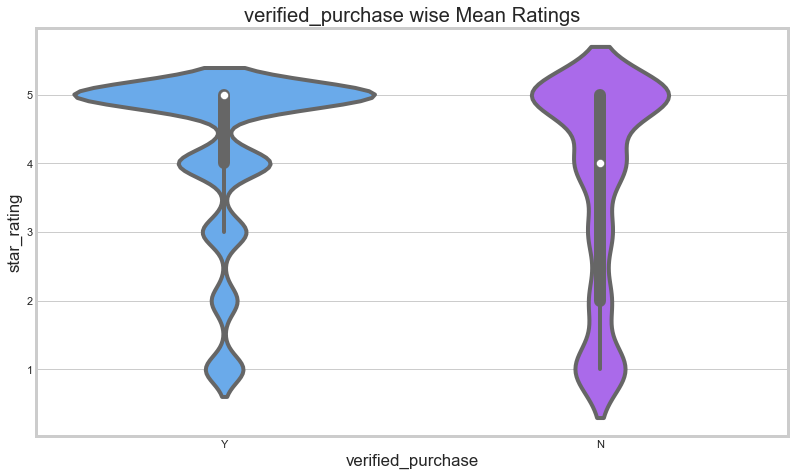

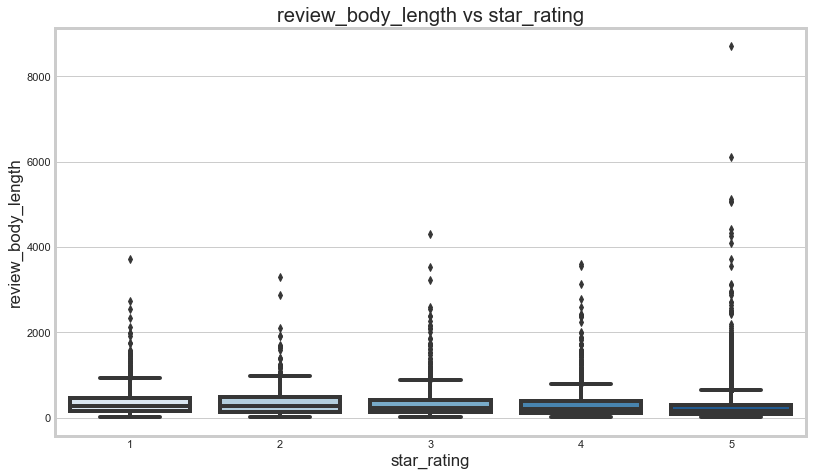

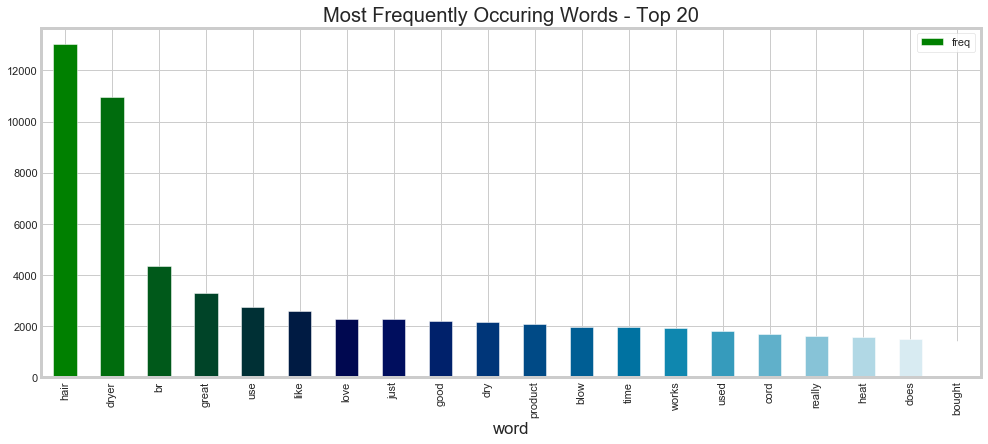

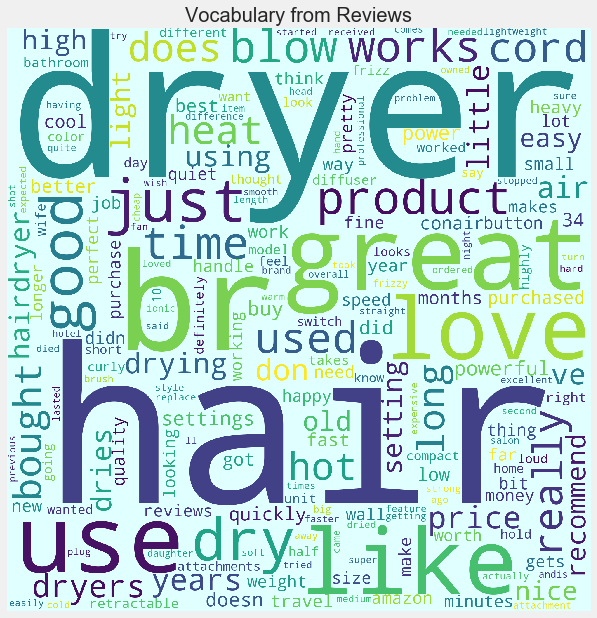

       word   freq
0      hair  13023
1     dryer  10961
2        br   4337
3     great   3312
4       use   2763
5      like   2579
6      love   2291
7      just   2284
8      good   2190
9       dry   2153
10  product   2107
11     blow   1968
12     time   1957
13    works   1918
14     used   1798
15     cord   1701
16   really   1632
17     heat   1567
18     does   1520
19   bought   1439


In [254]:
vis_data(data_total[0],"hair_dryer")

### Model a1

In [365]:
def process_data(data,all_data,aname=None):
    # 可视化数据
    # vis_data(data,"hair_dryer")
    
#     data['review_headline'][data.isnull()["review_headline"]] = "."
    comments = pd.concat([data['review_body']+" "+data['review_headline'],data['star_rating']],axis=1)
    comments.columns=['review','star_rating']
#     # 去除除了单词外的字符
#             review = re.sub('[^a-zA-Z]', ' ', comments['review'][i])
#             # 去除大小写的影响
#             review = review.lower()
#             review = review.split()
#             # 词干提取（stemming）
#             ps = PorterStemmer()
#             # 去除英语相应的助动词
#             review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
#             review = ' '.join(review)
    
    from sklearn.model_selection import train_test_split
    X_train,X_test, y_train, y_test =train_test_split(comments["review"],comments["star_rating"],test_size=0.1,random_state=777)
    with open("train.txt",'w',encoding='utf8') as f:
        for n_i in range(len(X_train)):
            f.write(str("__label__"+str(int(y_train[n_i]))+" "+X_train[n_i])+"\n")
        f.close()
    with open("test.txt",'w',encoding='utf8') as ff:
        for n_i in range(len(X_test)):
            ff.write(str("__label__"+str(int(y_test[n_i]))+" "+X_test[n_i])+"\n")
            
    # Data Prep
    data = pd.read_table("train.txt")
    data.to_csv("train.txt", index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

    # Modelling
    # This routine takes about 5 to 10 minutes 
    model = fasttext.train_supervised('train.txt',label_prefix='__label__', thread=4, epoch = 400)
    print(model.labels, 'are the labels or targets the model is predicting')
    test_data = pd.read_table('test.txt').values
    # To run the predict function, we need to remove the __label__1 and __label__2 from the testset.  
    new = [w[0].replace('__label__1 ', '') for w in test_data.tolist()]
    new = [w.replace('__label__2 ', '') for w in new]
    new = [w.replace('__label__3 ', '') for w in new]
    new = [w.replace('__label__4 ', '') for w in new]
    new = [w.replace('__label__5 ', '') for w in new]
    new = [w.replace('\n', '') for w in new]
    # Use the predict function 
    pred = model.predict(new)
    # check the first record outputs
    print(pred[0][0], 'is the predicted label')
    print(pred[0][1], 'is the probability score')
    # all_len = len(test_data)
    # print(all_len)
    # cnt = 0
    label_test = []
    label_score = []
    for i,tr in enumerate(pred[:][0]):
        label_score.append(int(tr[0].split("__")[2].split(" ")[0]))
        label_test.append(int(test_data[i][0].split("__")[2].split(" ")[0]))
    from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score,roc_auc_score
    print('accuracy:{}'.format(accuracy_score(label_test, label_score)))
    print('precision:{}'.format(precision_score(label_test, label_score,average='micro')))
    print('recall:{}'.format(recall_score(label_test, label_score,average='micro')))
    print('f1-score:{}'.format(f1_score(label_test, label_score,average='micro')))
    
    all_data["review_rating"] = 0
    all_data["reivew_star_rating"] = 0
    D = all_data["review_body"].values.tolist()
    new = [w.replace('\n', '') for w in D]
    
    from factor_analyzer import FactorAnalyzer
    fa = FactorAnalyzer(2)
    test_data = pd.DataFrame({"review_rating":all_data["review_rating"],"star_rating":all_data["star_rating"]})
    test_data.dropna(inplace=True)
    fa.fit(test_data)
    print(fa.loadings_)
    #     fa.fit_transform(test_data)#固定公共因子个数为1个
#     print("公因子方差:\n", fa.get_communalities())#公因子方差
#     print("\n成分矩阵:\n", fa.loadings)#成分矩阵
#     var = fa.get_factor_variance()#给出贡献率
#     print("\n解释的总方差（即贡献率）:\n", var)
#     fa_score = fa.get_scores(data)#因子得分
    print(fa_score.head())
    for i,tr in enumerate(model.predict(new)[:][0]):
        all_data["review_rating"][i] = int(tr[0].split("__")[2].split(" ")[0])
        # 评论0.7，评分0.3
        all_data["reivew_star_rating"] = round(all_data["review_rating"] * 0.6 + all_data["star_rating"] * 0.4)
    return all_data

### Model a2

In [117]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score,roc_auc_score
def process_data2(data,name=None):
    # 可视化数据
#     vis_data(data,"hair_dryer")
    data['review_headline'][data.isnull()["review_headline"]] = "."
    comments = pd.concat([data['review_body']+". "+data['review_headline'],data['star_rating']],axis=1)
    comments.columns=['review','star_rating']
    
    
    corpus = []
    for i in range(0, 2754):
        review = re.sub('[^a-zA-Z]', ' ', comments['review'][i])
        review = review.lower()
        review = review.split()
        ps = PorterStemmer()
        review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
        review = ' '.join(review)
        corpus.append(review)
        
    # creating bag of words
    from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

    cv = CountVectorizer(max_features = 2500)

    x = cv.fit_transform(corpus).toarray()
    y = comments["star_rating"].values

    print(x.shape)
    print(y.shape)
    
    from sklearn.model_selection import train_test_split

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 15)

    print(x_train.shape)
    print(y_train.shape)
    print(x_test.shape)
    print(y_test.shape)
    from sklearn.preprocessing import MinMaxScaler

    mm = MinMaxScaler()

    x_train = mm.fit_transform(x_train)
    x_test = mm.transform(x_test)
    
    
    params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]}
    
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import StratifiedKFold

    cv_object = StratifiedKFold(n_splits = 2)

    grid = GridSearchCV(estimator = model, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
    grid.fit(x_train, y_train.ravel())
    
    print("Best Parameter Combination : {}".format(grid.best_params_))
    
    print("Mean Cross Validation Accuracy - Train Set : {}".format(grid.cv_results_['mean_train_score'].mean()*100))
    print("Mean Cross Validation Accuracy - Validation Set : {}".format(grid.cv_results_['mean_test_score'].mean()*100))

    from sklearn.metrics import accuracy_score
    print("Accuracy Score for Test Set :", accuracy_score(y_test, y_pred))
    
    model = RandomForestClassifier(bootstrap=True,max_depth=100, min_samples_split= 8,n_estimators=100)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    print("Training Accuracy :", model.score(x_train, y_train))
    print("Testing Accuracy :", model.score(x_test, y_test))
    print('accuracy:{}'.format(accuracy_score(y_test, y_pred)))
    print('precision:{}'.format(precision_score(y_test, y_pred,average='macro')))
    print('recall:{}'.format(recall_score(y_test, y_pred,average='macro')))
    print('f1-score:{}'.format(f1_score(y_test, y_pred,average='macro')))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\27215\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# process_data2(data_total[0],"hair_dryer")

### Model a3

In [119]:
import string
import nltk
from nltk import PorterStemmer #
import re
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('wordnet')
nltk.download('vader_lexicon')

def process_data3(data,name=None):
    print(name,"desc")
    print(f"The number of {name} data",len(data))
    print(f"The {name} number of star_rating",len(data["star_rating"][(data["star_rating"]<=5) & (data["star_rating"]>=1)]))
    
    # 首先去除total_votes=0的 |(data["vine"]=='Y')
    data = data[(data["total_votes"]!=0)]
    print(f"The {name} useful number of total_votes",len(data))
    # 在对于help_votes/total_votes
    data["helpful_acc"] = data["helpful_votes"] / data["total_votes"]
    data = data[(data["helpful_acc"]>=0.5)]
    print(f"The {name} useful number of helpful_acc",len(data))
    # 在对于是否已经购买
    data = data[(data["verified_purchase"] == 'Y')]
    print(f"The {name} useful number of verified_purchase",len(data))
    # 可视化数据
#     vis_data(data,"hair_dryer")
    
    data['review_headline'][data.isnull()["review_headline"]] = "."
    comments = pd.concat([data['review_body']+". "+data['review_headline'],data['star_rating']],axis=1)
    comments.columns=['review','star_rating']
    
    # review_headline是存在空的
    stopwords = nltk.corpus.stopwords.words('english')
    
    # 不同的分词方法
    """
    词形还原（lemmatization），是把一个任何形式的语言词汇还原为一般形式（能表达完整语义），而词干提取

    （stemming）是抽取词的词干或词根形式（不一定能够表达完整语义）。词形还原和词干提取是词形规范化的两类
    重要方式，都能够达到有效归并词形的目的，二者既有联系也有区别



    现将共同点和联系总结为以下４方面：
      （１）目标一致。词干提取和词形还原的目标均为将词的屈折形态或派生形态简化或归并为词干（stem）
    或原形的基础形式，都是一种对词的不同形态的统一归并的过程。
      （２）结果部分交叉。词干提取和词形还原不是互斥关系，其结果是有部分交叉的。一部分词利用这两类方法都能达到相同的词形转换效果。如“dogs”的词
    干为“dog”，其原形也为“dog”。
      （３）主流实现方法类似。目前实现词干提取和词形还原的主流实现方法均是利用语言中存在的规则或利用词典映射提取词干或获得词的原形。
      （４）应用领域相似。主要应用于信息检索和文本、自然语言处理等方面，二者均是这些应用的基本步骤



    二者的区别归纳为以下５方面：
      （１）在原理上，词干提取主要是采用“缩减”的方法，将词转换为词干，如将“cats”处理为“cat”，将“effective”处理为“effect”。而词形还原主要采用“转变”
    的方法，将词转变为其原形，如将“drove”处理为“drive”，将“driving”处理为“drive”。
      （２）在复杂性上，词干提取方法相对简单，词形还原则需要返回词的原形，需要对词形进行分析，不仅要进行词缀的转化，还要进行词性识别，区分相同词形但
    原形不同的词的差别。词性标注的准确率也直接影响词形还原的准确率，因此，词形还原更为复杂。
      （３）在实现方法上，虽然词干提取和词形还原实现的主流方法类似，但二者在具体实现上各有侧重。词干提取的实现方法主要利用规则变化进行词缀的去除和缩减，从而达到词的简化效果。词形还原则相对较复杂，有复杂的形态变化，单纯依据规则无法很好地完成。其更依赖于词典，进行词形变化和原形的映射，生成词典中的有效词。

    （４）在结果上，词干提取和词形还原也有部分区别。词干提取的结果可能并不是完整的、具有意义的词，而只是词的一部分，如“revival”词干提取的结果为“reviv”，“ailiner”词干提取的结果为“airlin”。而经词形还原处理后获得的结果是具有一定意义的、完整的词，一般为词典中的有效词。

    （５）在应用领域上，同样各有侧重。虽然二者均被应用于信息检索和文本处理中，但侧重不同。词干提取更多被应用于信息检索领域，如Solr、Lucene等，用于扩展检索，粒度较粗。词形还原更主要被应用于文本挖掘、自然语言处理，用于更细粒度、更为准确的文本分析和表达



    相对而言，词干提取是简单的轻量级的词形归并方式，最后获得的结果为词干，并不一定具有实际意义。词形还原处理相对复杂，获得结果为词的原形，能够承载一定意义，与词干提取相比，更具有研究和应用价值
    """
    
    ps = PorterStemmer()
    wn = nltk.WordNetLemmatizer()
    
    def clean_stem (sent): 
        temp1 ="".join(x for x in sent if x not in string.punctuation)
        temp2 = re.split('\W+',temp1.lower())
        temp3 = [ps.stem(x) for x in temp2 if x not in stopwords]
        return temp3

    def clean_lemma (sent): 
        temp1 ="".join(x for x in sent if x not in string.punctuation)
        temp2 = re.split('\W+',temp1.lower())
        temp3 = [wn.lemmatize(x) for x in temp2 if x not in stopwords]
        return temp3
    
    # 进行分词、编码
    vectstem = TfidfVectorizer(analyzer=clean_stem)
    vectlemm = TfidfVectorizer(analyzer=clean_lemma)

    textfeatures=vectstem.fit_transform(comments['review'])
    print("Stemmed - " + str(len(vectstem.get_feature_names())))

    vectlemm.fit_transform(comments['review'])
    print("Lemmatized - " + str(len(vectlemm.get_feature_names())))
    
    print(pd.DataFrame(textfeatures.toarray()).head(15))
    
    textmatrix = pd.DataFrame(textfeatures.toarray(),columns=vectstem.vocabulary_)
    print(textmatrix.head(5))
    
    sum_scores = pd.DataFrame(textmatrix.sum(),columns=['sum_scores_TFIDF'])
    sum_scores.head(10)
    
    print(sum_scores.sort_values(by='sum_scores_TFIDF',ascending=True)[:5] )
    print(sum_scores.sort_values(by='sum_scores_TFIDF',ascending=False)[:5])
    
    pd.set_option('display.max_colwidth', 0)
    print(comments.head())
    
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    # 一个简单的基于规则的情感分析模型，其中组合了词汇特征来识别情感强度
    # 正、中性、负和表示一个聚合分数的化合态
    sid = SentimentIntensityAnalyzer()
    
    def sentiment(x):
        score = sid.polarity_scores(x)
        return score['compound']

    #sentiment(happy)
    comments['sentiment']= comments['review'].apply(lambda x : sentiment(x))
    
    # Feature 2 : Length of string

    comments['length'] = comments['review'].apply(lambda x : len(re.split('\W+',x)))
    comments[comments['star_rating']==5].head(10)

    # before we proceed - we need to convert all true >> 1 and false as 0
    print(comments.head(5))
    print(comments[comments['star_rating']==1].head(5))
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import precision_recall_fscore_support as score
    from sklearn.model_selection import train_test_split

    # need to reset index of the comments column to match with textfeatures
    new_sentiment = comments.sentiment.reset_index()['sentiment']
    new_length = comments.length.reset_index()['length']

    x_features = pd.concat([new_sentiment,new_length,
                            pd.DataFrame(textfeatures.toarray(),
                            columns=vectstem.vocabulary_)],axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x_features,comments.star_rating,test_size=0.2)

    rf = RandomForestClassifier(n_jobs=-1,n_estimators=50,max_depth=90)
    rfmodel=rf.fit(x_train,y_train)

    y_pred = rfmodel.predict(x_test)
    print(sorted(zip(rfmodel.feature_importances_,x_train.columns),reverse=True)[0:10])
    
    print('accuracy:{}'.format(accuracy_score(y_test, y_pred)))
    print('precision:{}'.format(precision_score(y_test, y_pred,average='macro')))
    print('recall:{}'.format(recall_score(y_test, y_pred,average='macro')))
    print('f1-score:{}'.format(f1_score(y_test, y_pred,average='macro')))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\27215\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\27215\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Stemmed has features 18 % lower than that of Lemmatized.
# process_data3(data_total[0],"hair_dryer")

### have three different credit 

### 这里说明的是如何获得可信度高的训练数据
1. 然后是选择total_votes不为0的评论数据的较为可信的评论数据
2. 在是使用定义的标准（heldpllopful_vitotes / total_vote）>=0.5,认为是较为可信的
3. 然后就是通过是否购买商品，这里选择的是已经购买商品的，评论才最可靠的


**通过3层的较为可信的，层层递进筛选，可以得到认为是评论和用户评价非常可靠的评论数据**

----- 待定首先如果vine=Y，也就是亚马逊会员的话，我们默认其评论都是真实的

#### 如果满足下列条件可以认为其是较为可靠的
1.如果用户购买，就认为评论是较为可靠的
2.如果用户对评论进行投票并且定义的标准（heldpllopful_vitotes / total_vote）>=0.5则也认为是较为可靠的
**这里是通过或的关系来进行筛选的**


### 其他的情况则认为是不可靠的评论

In [366]:
def diff_credit(data,name=None):
    print("评论数目为空的个数：",data["review_body"].isnull().any().sum())
    data.dropna(axis=0, how='any', inplace=True)
    print(name,"desc")
    print(f"The number of {name} data",len(data))
    print(f"The {name} number of star_rating",len(data["star_rating"][(data["star_rating"]<=5) & (data["star_rating"]>=1)]))

    data = data[(((data["verified_purchase"] == 'Y'))|((data["total_votes"]!=0)&((data["helpful_votes"] / data["total_votes"])>=0.5)))]
    indexs = (data["total_votes"]!=0)&((data["helpful_votes"] / data["total_votes"])>=0.5)&(data["verified_purchase"] == 'Y')
    credit = data[(1-indexs).astype(np.bool)]
    print(f"The {name} credit number of verified_purchase",len(credit))
    most_credit = data[((data["total_votes"]!=0)&((data["helpful_votes"] / data["total_votes"])>=0.5)&(data["verified_purchase"] == 'Y'))]
    print(f"The {name} most credit number of verified_purchase",len(most_credit))
    data.dropna(axis=0, how='any', inplace=True)
    # 可视化数据
    #vis_data(most_credit,"most_credit hair_dryer")
    #vis_data(data,"credit hair_dryer")
    # 选取效果最好的模型 为对评论进行编码模型 a1
    print(data)
    number_comments_data = process_data(most_credit,data,name)
    
    #reivew_star_rating
    # review_rating
    number_comments_data["verified_purchase"][number_comments_data["verified_purchase"]=='Y'] = True
    number_comments_data["verified_purchase"][number_comments_data["verified_purchase"]=='N'] = False
    number_comments_data["verified_purchase"] = number_comments_data["verified_purchase"].astype(bool)
    # [number_comments_data["product_parent"]==711329162]
    one_some_data = number_comments_data
    some_s = one_some_data["star_rating"].value_counts()
    
    some_s.sort_index(inplace=True)
    plt.figure()
    try:
        one = some_s[5]
    except:
        one = 0
    try:
        two = sum(some_s[1:3])
    except:
        two = 0
    Some_NPS_score = round (100*(one-two)/sum(some_s),2)  
    print (" NPS score of Some is : "  + str(Some_NPS_score))
    #better NPS than overall amazon
    some_s.plot(kind='bar',title='Amazon customer ratings',figsize=(6,6),style='Solarize_Light2')
    
    
    testData = one_some_data[one_some_data["verified_purchase"]==False]
    print(testData)
    print(one_some_data["verified_purchase"].value_counts())
    one_some_data["reivew_star_rating"].hist(by=one_some_data["verified_purchase"],figsize=(12,6))
    
    plus_kindle = one_some_data[one_some_data["verified_purchase"]==True]["reivew_star_rating"].value_counts()
    plus_kindle.sort_index(inplace=True)
    recomm_NPS = round(100*(sum(plus_kindle[4:5])-sum(plus_kindle[1:2]))/sum(plus_kindle),2)
    minus_kindle = one_some_data[one_some_data["verified_purchase"]==False]["reivew_star_rating"].value_counts()
    minus_kindle.sort_index(inplace=True)
    notrecomm_NPS = round(100*(sum(minus_kindle[4:5])-sum(minus_kindle[1:2]))/sum(minus_kindle),2)
    print("Those who recommend amazon something generate high NPS score of " + str(recomm_NPS))
    print("Those who DO NOT recommend something produce a NPS score of " + str(notrecomm_NPS))
    print(" ~ pretty much correct definition of NPS score")
    return number_comments_data
    
    

In [367]:
number_comments_data = diff_credit(data_total[0],"hair_dryer")
print(number_comments_data)
# microwave
# number_comments_data.to_csv("new_pacifier.csv")

评论数目为空的个数： 0
hair_dryer desc
The number of hair_dryer data 11468
The hair_dryer number of star_rating 11468
The hair_dryer credit number of verified_purchase 7887
The hair_dryer most credit number of verified_purchase 2754
                customer_id  product_parent  star_rating  helpful_votes vine  \
review_id                                                                      
R9T1FE2ZX2X04      34678741       732252283            5              0    N   
RE36JAD5V53PO      11599505       670161917            4              0    N   
RIDHM8B7SCCV3       2282190        16483457            5              0    N   
R14QGWPCHU9LSE     43669858       253917972            5              0    N   
R230LCPQDOFJJZ     51995766       919751065            5              0    N   
...                     ...             ...          ...            ...  ...   
R2O50YNP83CG34     35599734       919751065            5             14    N   
R2JQPUYU65C4QD     43977044       694290590            1 

ValueError: array must not contain infs or NaNs

### b:时间序列分析 先分时间后分产品种类

In [22]:
sns.set(rc={'figure.facecolor':'white'})
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
def average_day_month(every_group, year=None):
    # 删除分组后的hour列，形成的结果数据是日平均，所以不在需要小时数据
    if year:
        every_group.drop("Month", axis=1, inplace=True)
        every_group.drop("Day", axis=1, inplace=True)
        every_group.drop("Season", axis=1, inplace=True)
    else:
        every_group.drop("Month", axis=1, inplace=True)
        every_group.drop("Day", axis=1, inplace=True)
    
    values_n = every_group["reivew_star_rating"].value_counts()
#     print(every_group["reivew_star_rating"])
    values_n.sort_index(inplace=True)
    try:
        one = values_n[5]
    except:
        one = 0
    try:
        two = sum(values_n[1:3])
    except:
        two = 0
    Some_NPS_score = round (100*(one-two)/sum(values_n),2)   
    every_group["CPS"] = Some_NPS_score
    every_group["review_num"] = every_group["review_num"].sum()
    every_group["verified_purchase_num"] = every_group["verified_purchase"][every_group["verified_purchase"]==True].sum() 
    return pd.DataFrame([every_group.iloc[0, :]], columns=every_group.columns)
    
def predict_time_series(season_data):
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    # Autocorrelation of humidity of San Diego
    season_data = season_data.dropna()
#     自相关（ACF）和偏自相关（PACF）置信区间被画成圆锥形。默认情况下，置信区间这被设置为95%。
    
    import statsmodels.api as sm
    from numpy.random import normal, seed
    from scipy.stats import norm
    from statsmodels.tsa.arima_model import ARMA
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.tsa.arima_process import ArmaProcess
    from pylab import rcParams
    from statsmodels.tsa.arima_model import ARIMA
    
    
#     print(season_data)
    test_time_series = pd.DataFrame({"Date":pd.to_datetime(season_data["review_date"].values),"CPS":season_data["CPS"].values})
    test_time_series.set_index('Date',inplace=True,drop=True)
    print(test_time_series)
    test_time_series["CPS"].plot()
    plt.savefig("time_series.png")
    plt.ylabel("CPS")
    plt.title("CPS over year time")
    plt.show()
    
    plot_acf(test_time_series["CPS"],title="CPS")
    plt.savefig("time_series_acf.png")
    plt.show()
    
    plot_pacf(test_time_series["CPS"],title="CPS")
    plt.savefig("time_series_pacf.png")
    plt.show()
    
    print('原始序列的检验结果为：',adfuller(test_time_series["CPS"]))
    print(test_time_series.shape)
    D_data = test_time_series["CPS"].diff().iloc[1:].values
    
#     D_data.plot()
#     plt.show()
    
    plot_acf(D_data,title="CPS")
    plt.savefig("time_series_diff_acf.png")
    plt.show()
    
    plot_pacf(D_data,title="CPS")
    plt.savefig("time_series_diff_pacf.png")
    plt.show()
    
    from statsmodels.stats.diagnostic import acorr_ljungbox
    print('差分序列的ADF 检验结果为：',adfuller(D_data))
    print(u'差分序列的白噪声检验结果：',acorr_ljungbox(D_data, lags= 1)) #返回统计量和 p 
    pmax = int(len(D_data) / 10)    #一般阶数不超过 length /10
    qmax = int(len(D_data) / 10)
    bic_matrix = []
    for p in range(pmax +1):
        temp= []
        for q in range(qmax+1):
            try:
                temp.append(ARIMA(test_time_series, (p, 1, q)).fit().bic)
            except:
                temp.append(None)
            bic_matrix.append(temp)
 
    bic_matrix = pd.DataFrame(bic_matrix)   #将其转换成Dataframe 数据结构
    p,q = bic_matrix.stack().idxmin()   #先使用stack 展平， 然后使用 idxmin 找出最小值的位置
    print(u'BIC 最小的p值 和 q 值：%s,%s' %(p,q))  #  BIC 最小的p值 和 q 值：0,1
    #所以可以建立ARIMA 模型，ARIMA(0,1,1)
    model = ARIMA(test_time_series, (p,1,q)).fit()
    model.summary2()        #生成一份模型报告
#     print(model.forecast(5))   #为未来2天进行预测， 返回预测结果， 标准误差， 和置信区间
    res = model.forecast(2)
    print(test_time_series)
    print("2016",res[0][0])
    print("2017",res[0][1])
#     plt.savefig("time_series_add.png")
#     plt.show()

def time_series(data,least_com,name=None):
    # 对时间进行分箱操作 年？季度？月？
    # 针对某一类产品
#     data = data[data["product_parent"]==711329162]
    sns.set(rc={'figure.facecolor':'white'})
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    import math
    data["Year"] = 0
    data["Month"] = 0
    data["Day"] = 0
    data["Season"] = 0
    data["CPS"] = 0
    data["review_num"] = 1
    data["verified_purchase_num"] = 1
    for i,d in enumerate(data["review_date"]):
        m,d,y = data["review_date"][i].split("/")
        j = math.ceil(int(m)/3)
        data["Year"][i] = y
        data["Month"][i] = m
        data["Day"][i] = d
        data["Season"][i] = j
    
    # 按年进行分组
    group_by_year = data.groupby(["Year"])
    # 进行分组处理
    year_data = group_by_year.apply(average_day_month, year=True)
    year_data = year_data[year_data["review_num"]>least_com]
    year_time_series = pd.DataFrame({"CPS":year_data["CPS"].values,
                                    "review_num":year_data["review_num"].values,
                                    "verified_purchase_num":year_data["verified_purchase_num"].values},index=year_data["Year"])
    print(year_time_series)
    plt.title(f'{name} CPS over time(Yearly frequency)')
    plt.xlabel("datetime")
    plt.ylabel("CPS")
    year_time_series["CPS"].plot()
    plt.show()
    
    plt.title(f'{name} review_num   over time(Yearly frequency)')
    plt.xlabel("datetime")
    plt.ylabel("review_num")
    year_time_series["review_num"].plot()
    plt.show()
    
    plt.title(f'{name} verified_purchase_num over time(Yearly frequency)')
    plt.xlabel("datetime")
    plt.ylabel("verified_purchase_num")
    year_time_series["verified_purchase_num"].plot()
    plt.show()
    
    ######################################################################  按季度进行分组
    group_by_season = data.groupby(["Year","Season"])
    
    # 进行分组处理,
    season_data = group_by_season.apply(average_day_month, year=False)
    season_data = season_data[season_data["review_num"]>least_com]
#     print(season_data)
    season_time_series = pd.DataFrame({"CPS":season_data["CPS"].values,
                                    "review_num":season_data["review_num"].values,
                                    "verified_purchase_num":season_data["verified_purchase_num"].values,"Year":season_data["Year"],"Season":season_data["Season"].values})
    # 对季度进行可视化
#     trace = go.Scatter3d(
#     x = season_time_series['Year'],
#     y = season_time_series['Season'],
#     z = season_time_series['CPS'],
#     mode='markers',
#     name = name,
#     marker=dict(
#         size=10,
#         color = season_data['reivew_star_rating'],
#         colorscale = 'Viridis',))
#     df = [trace]
#     layout = go.Layout(
#         title = 'Length vs Frequency word vs Ratings',plot_bgcolor='#ffffff',paper_bgcolor='#ffffff',
#         margin=dict(
#             l=0,
#             r=0,
#             b=0,
#             t=0)
#     )
#     fig = go.Figure(data = df, layout = layout)
#     iplot(fig)
    

#     trace = go.Scatter3d(
#     x = season_time_series['Year'],
#     y = season_time_series['Season'],
#     z = season_time_series['verified_purchase_num'],
#     mode='markers',
#     name = name,
#     marker=dict(
#         size=10,
#         color = season_data['reivew_star_rating'],
#         colorscale = 'Viridis',))
#     df = [trace]
#     layout = go.Layout(
#         title = 'Length vs Frequency word vs Ratings',plot_bgcolor='#ffffff',paper_bgcolor='#ffffff',
#         margin=dict(
#             l=0,
#             r=0,
#             b=0,
#             t=0  ) )
#     fig = go.Figure(data = df, layout = layout)
#     iplot(fig)
    
#     trace = go.Scatter3d(
#     x = season_time_series['Year'],
#     y = season_time_series['Season'],
#     z = season_time_series['review_num'],
#     mode='markers',
#     name = name,
#     marker=dict(
#         size=10,
#         color = season_data['reivew_star_rating'],
#         colorscale = 'Viridis',))
#     df = [trace]
#     layout = go.Layout(
#         title = 'Length vs Frequency word vs Ratings',plot_bgcolor='#ffffff',paper_bgcolor='#ffffff',
#         margin=dict(
#             l=0,
#             r=0,
#             b=0,
#             t=0  ) )
#     fig = go.Figure(data = df, layout = layout)
#     iplot(fig)
    predict_time_series(year_data)
    
#     predict_time_series(season_data)
    

                customer_id  product_parent  star_rating  helpful_votes vine  \
review_id                                                                      
R9T1FE2ZX2X04      34678741       732252283            5              0    N   
RE36JAD5V53PO      11599505       670161917            4              0    N   
RIDHM8B7SCCV3       2282190        16483457            5              0    N   
R14QGWPCHU9LSE     43669858       253917972            5              0    N   
R230LCPQDOFJJZ     51995766       919751065            5              0    N   
...                     ...             ...          ...            ...  ...   
R2O50YNP83CG34     35599734       919751065            5             14    N   
R2JQPUYU65C4QD     43977044       694290590            1             26    N   
R3GO6L5PWBS0IW     37733836       694290590            5              4    N   
R3JMGN42OJCL97     38947355       694290590            5             78    N   
R2XM83JYE2KDE2     43740490       694290

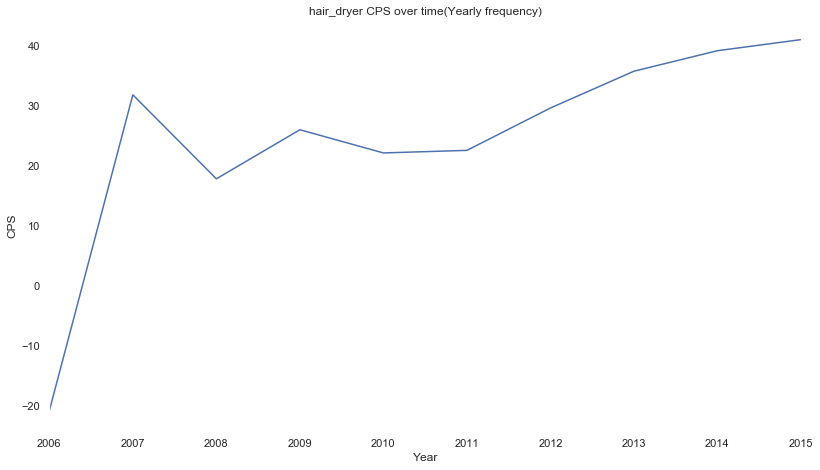

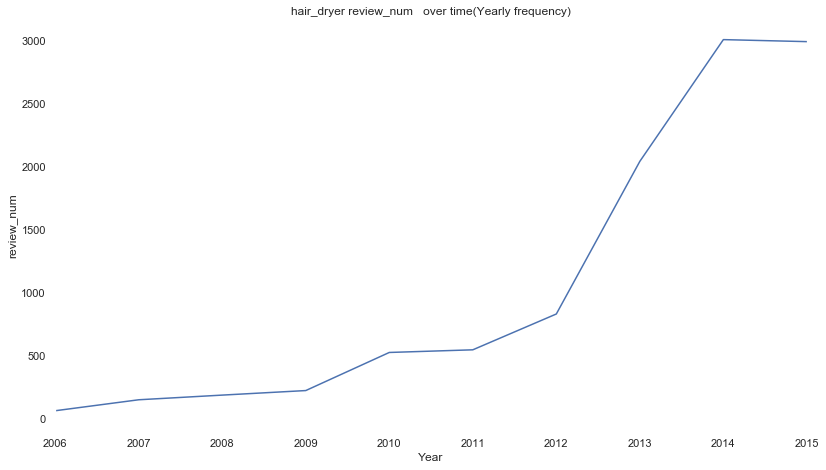

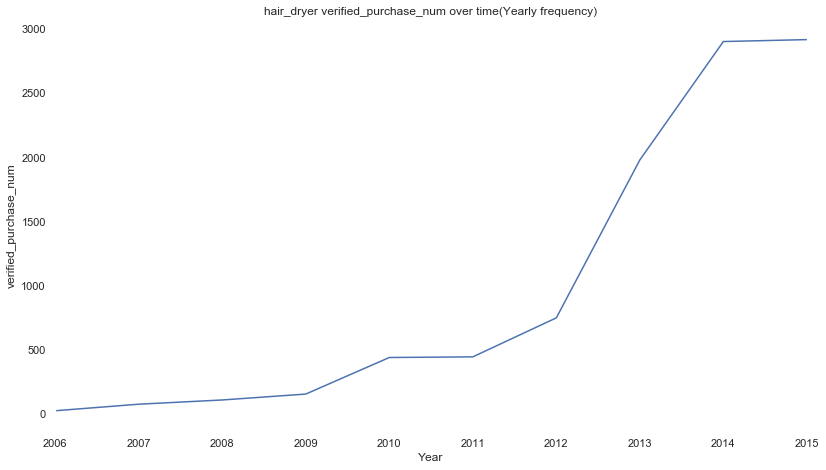

              CPS
Date             
2006-12-02 -20.90
2007-12-31  31.82
2008-12-31  17.80
2009-12-28  25.99
2010-12-31  22.12
2011-12-31  22.55
2012-12-31  29.62
2013-12-31  35.76
2014-12-31  39.18
2015-08-31  41.03


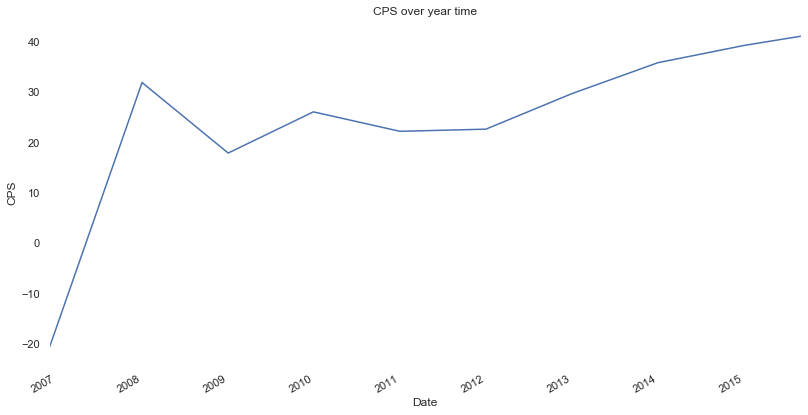

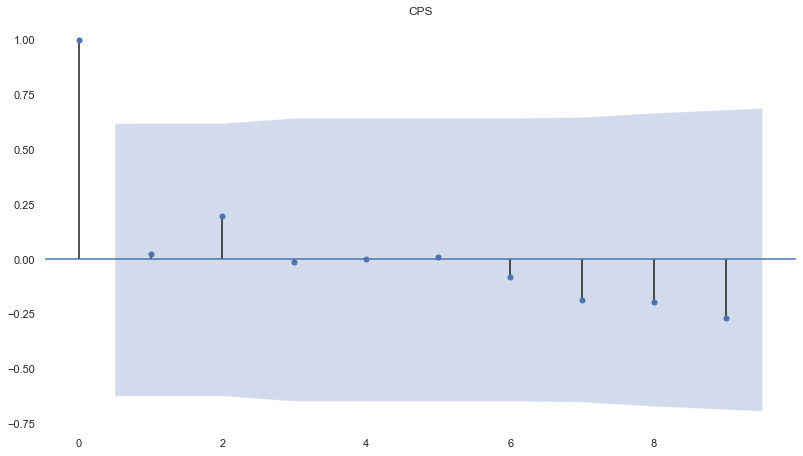

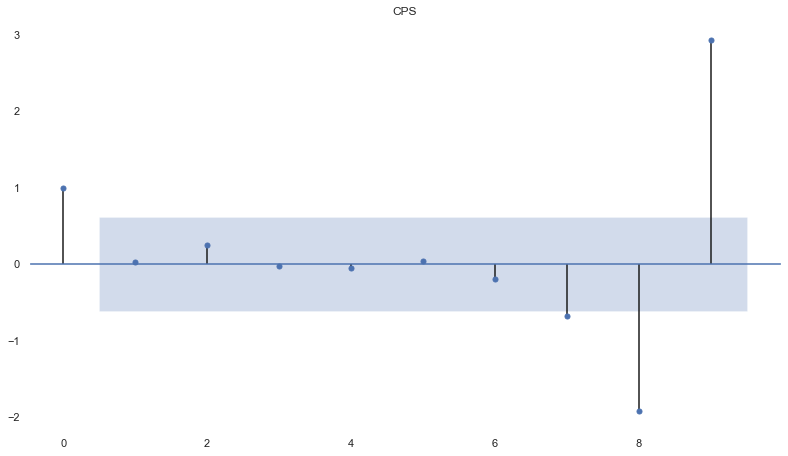

原始序列的检验结果为： (1.1180251525481786, 0.9953675616467965, 3, 6, {'1%': -5.354256481481482, '5%': -3.6462381481481483, '10%': -2.901197777777778}, 31.05302216986678)
(10, 1)


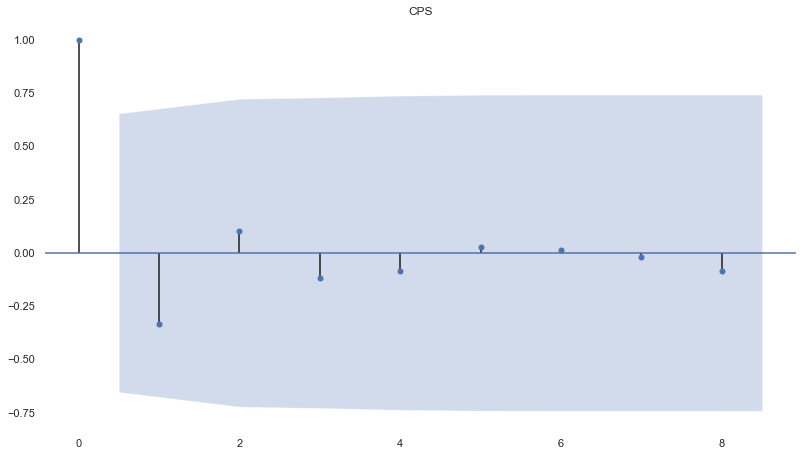

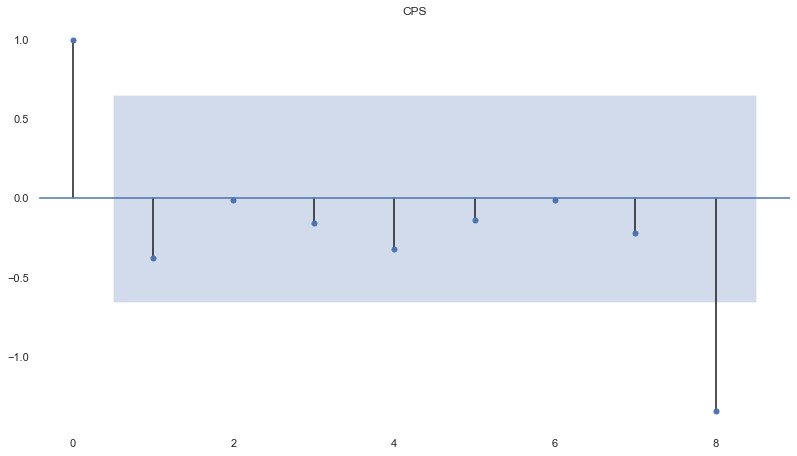

差分序列的ADF 检验结果为： (-2.2324896362849698, 0.1946655681831937, 2, 6, {'1%': -5.354256481481482, '5%': -3.6462381481481483, '10%': -2.901197777777778}, 33.91855077821441)
差分序列的白噪声检验结果： (array([1.37475548]), array([0.2409965]))
BIC 最小的p值 和 q 值：0,0
              CPS
Date             
2006-12-02 -20.90
2007-12-31  31.82
2008-12-31  17.80
2009-12-28  25.99
2010-12-31  22.12
2011-12-31  22.55
2012-12-31  29.62
2013-12-31  35.76
2014-12-31  39.18
2015-08-31  41.03
2016 47.91111111111111
2017 54.79222222222222


In [23]:
print(number_comments_data)
copy_data = number_comments_data.copy()
copy_data2 = number_comments_data.copy()
time_series(copy_data,20,"hair_dryer")

### 使用CSP研究潜在成功或失败的产品的因素

### 首先用每个产品种类的评论数进行筛选(>20)，在通过cps的大小进行筛选是否成功，然后通过评论的情感倾向，筛选评论为正相关的

In [336]:
sns.set(rc={'figure.facecolor':'white'})
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
def get_most_frequency(data,name=None):
    from sklearn.feature_extraction.text import TfidfVectorizer
    # 进行词频的统计
    cv = TfidfVectorizer(stop_words = 'english')
    words = cv.fit_transform(data[name])
    sum_words = words.sum(axis=0)


    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
    print(f"frequency for {name}:",frequency[:20])
    plt.style.use('fivethirtyeight')
    color = plt.cm.ocean(np.linspace(0, 1, 20))
    sns.set_style("whitegrid")
    frequency.head(40).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
    plt.title("Most Frequently Occuring Words - Top 40")
#     plt.savefig('7.png',dpi=200, bbox_inches='tight')
    plt.show()

    
    
    ## 词云图
    from wordcloud import WordCloud

    wordcloud = WordCloud(background_color = 'lightcyan', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.title(f"Vocabulary from {name}", fontsize = 20)
#     plt.savefig('8.png',dpi=200, bbox_inches='tight')
    
    plt.show()
    return frequency

def average_day_month(every_group, year=None):
    # 删除分组后的hour列，形成的结果数据是日平均，所以不在需要小时数据
    if year:
        every_group.drop("Month", axis=1, inplace=True)
        every_group.drop("Day", axis=1, inplace=True)
        every_group.drop("Season", axis=1, inplace=True)
    else:
        every_group.drop("Month", axis=1, inplace=True)
        every_group.drop("Day", axis=1, inplace=True)
    
    values_n = every_group["reivew_star_rating"].value_counts()
#     print(every_group["reivew_star_rating"])
    values_n.sort_index(inplace=True)
    try:
        one = values_n[5]
    except:
        one = 0
    try:
        two = sum(values_n[1:3])
    except:
        two = 0
    Some_NPS_score = round (100*(one-two)/sum(values_n),2)   
    every_group["CPS"] = Some_NPS_score
    every_group["review_num"] = every_group["review_num"].sum()
    every_group["verified_purchase_num"] = every_group["verified_purchase"][every_group["verified_purchase"]==True].sum() 
    return pd.DataFrame([every_group.iloc[0, :]], columns=every_group.columns)    
def kind_func(every_group):
    # 删除分组后的hour列，形成的结果数据是日平均，所以不在需要小时数据
    values_n = every_group["reivew_star_rating"].value_counts()
#     print(every_group["reivew_star_rating"])
    values_n.sort_index(inplace=True)
#     print(values_n)
    try:
        one = values_n[5]
    except:
        one = 0
    try:
        two = sum(values_n[1:3])
    except:
        two = 0
    Some_NPS_score = round (100*(one-two)/sum(values_n),2)    
    every_group["CPS"] = Some_NPS_score
    every_group["review_num"] = every_group["review_num"].sum()
    every_group["verified_purchase_num"] = every_group["verified_purchase"][every_group["verified_purchase"]==True].sum() 
    return pd.DataFrame([every_group.iloc[0, :]], columns=every_group.columns)

def most_import_factor(data,least_com,name=None,success=True):
#     color = plt.cm.copper(np.linspace(40, 1, 60))
#     some_most_product = data['product_parent'].value_counts()[:20]
#     some_most_product.plot.bar(color = color, figsize = (15, 9),colormap="#ffffff")
#     plt.title(f'Distribution of {name} in kinds(1-20st)', fontsize = 20)
#     plt.xlabel(f'{hair_dryer} kind')
#     plt.ylabel('count')
# #     plt.savefig('1.png',dpi=200, bbox_inches='tight')
#     plt.show()
#     print(data)
#     print(data)
#     data.plot.scatter(x='product_parent', y='b')
    data["review_num"] = 1
    data["verified_purchase_num"] = 1
    group_by_kind = data.groupby(["product_parent"])
#     # 进行分组处理
    kind_data = group_by_kind.apply(kind_func)
#     kind_data.set_index("product_parent",inplace=True,drop=True)
    # 有拐点可知
    kind_data.to_csv(f"{name}_de_com.csv")
    kind_data = kind_data[kind_data["review_num"]>least_com]
#     print(kind_data)
#     vis_data(kind_data,"hair_dryer")
    if success == True:
        kind_data.sort_values("CPS",inplace=True,ascending=False)
    else:
        kind_data.sort_values("CPS",inplace=True,ascending=True)
    new_data = pd.DataFrame({"CPS":kind_data["CPS"].values,
                "review_num":kind_data["review_num"].values,
                "verified_purchase_num":kind_data["verified_purchase_num"].values},index=kind_data["product_parent"])
    # 筛选CPS>50分的商品的种类，为成功的种类
    if success == True:
        success_kinds = new_data[new_data["CPS"]>50]
    else:
        success_kinds = new_data[new_data["CPS"]< 0]
        
    pre_data = data[data["product_parent"]==success_kinds.index[0]]
    for ii,product_id in enumerate(success_kinds.index):
        if ii == 0:
            continue
        pre_data = pd.concat([pre_data,data[data["product_parent"]==product_id]])
#     print(pre_data)
    
   
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    
    sid = SentimentIntensityAnalyzer()
    def sentiment(x):
        score = sid.polarity_scores(x)
        return score['compound']

    #sentiment(happy)
    pre_data['review_body_score']= pre_data["review_headline"].apply(lambda x : sentiment(x))
    pre_data['review_headline_score']= pre_data["review_headline"].apply(lambda x : sentiment(x))
    if success == True:
        new_pre_data = pre_data[pre_data["review_body_score"]>0]
    else:
        new_pre_data = pre_data[pre_data["review_body_score"]<0]
    listss = new_pre_data["product_parent"].unique()
    if success == True:
        print("较为成功的几个种类：",listss)
    else:
        print("较为失败的几个种类：",listss)
     # 对于评论body进行关键词提取
    review_body_frequency_word = get_most_frequency(new_pre_data,name="review_body")
    
    # 对于评论headline进行关键词提取
    review_headline_frequency_word = get_most_frequency(new_pre_data,name="review_headline")
    
    data_list = review_body_frequency_word['word'].values.tolist()[:30]      # 将某一列读到列表中

    df_list = review_headline_frequency_word['word'].values.tolist()[:30]
    if success ==True:
        a = [x for x in data_list if x in df_list]  # 两个列表表都存在
    else:
        a = [x for x in data_list if x not in df_list] + [y for y in df_list if y not in data_list]
    print("关键词为:",a)
    """
        较为成功的几个种类： [959834931 977457747 768062995 591023894 407404113 453645026 466064538
     945323010 376749538 218800429 290876515 646149518 593915883 380013605
     582752797 391944105 646926938  16483457 276205451 253762851 833461643
     535977674 179801564 253917972 531585937 486589264 286798751 316756803
     902572429 974237252 357308868]
         较为失败的几个种类： [588999286 346326614 955015830 932955324 734632472  54987170 981727854
     868768702 194533684 805407843 475989673 199558933 221722169 218297570
     685652978 241892378 196041133 862140913 341174535 635386699 187812876
     843035023 345449343 630355634 496940864 919751065 888313825 619941271
     664218299 748065701 223051644 197856712 568981338  74735317 238410319
     252448367 569841544 107341965 127343313 258419037    423960 153523919
     711329162 415057628 694290590 676407800 963019694  66259499 303775294
     392681682 815035474 176210327 122140779  47684938 328811288 897437023
     415529274 772841097 963066492 814216548 108191918 235105995 494548935
     121009604 560455235 758099411 732252283 726227850 195677102 531479992
     670161917 396337866 983445543 486774008  26711891 168649310 761176783
     442401590 443954263 614083399  57056668 918034537 828468145 109106777]
    """
    sum1 = 0
    sum2 = 0
    cnt1 = 0
    cnt2 = 0
    for ll in listss:
        sum1 = sum1 + data[data["product_parent"]==int(ll)].shape[0]
        sum2 = sum2 + data[data["product_parent"]==int(ll)]["star_rating"].sum()
        cnt1 += 1
        cnt2 = cnt2 + data[data["product_parent"]==int(ll)].shape[0]
    print("潜在成功种类产品评论数据其平均值为（热度）：",sum1/cnt1)
    print("潜在成功种类产品评star_rating据其平均值为（热度）：",sum2/cnt2)
    first = listss[0]
    print(listss)
    if len(listss) < 2:
        second = listss[1]
    else:
        second = listss[2]
    kind_some_data = data[data["product_parent"]==int(first)]
    kind_some_data2 = data[data["product_parent"]==int(second)]
    time_series(kind_some_data,0,"hair_dryer "+str(first))
    time_series(kind_some_data2,0,"hair_dryer "+str(second))
    

较为成功的几个种类： [945323010 959834931 977457747 768062995 380013605 466064538 453645026
 376749538 591023894 290876515 316756803 407404113 391944105 276205451
 646149518 593915883 646926938  16483457 486589264]
frequency for review_body:         word       freq
0       hair  52.472312
1      dryer  41.125358
2       love  22.964021
3      great  22.266316
4         br  16.911331
5       blow  15.623990
6        dry  15.391813
7       time  14.781560
8      dries  14.545130
9       best  14.020684
10    really  13.634603
11      used  13.345482
12      like  13.103802
13   product  13.087524
14      good  13.078316
15     works  12.956957
16      fast  12.851226
17       use  11.669964
18  powerful  11.524419
19      long  10.809297


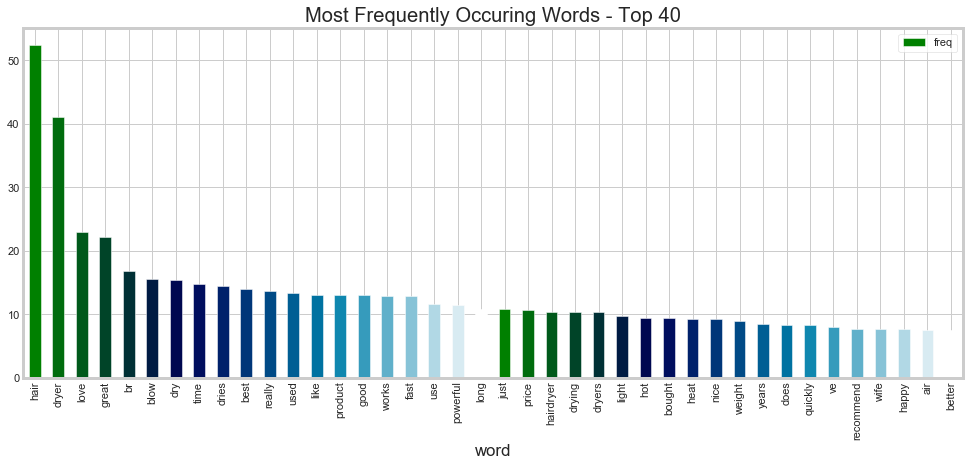

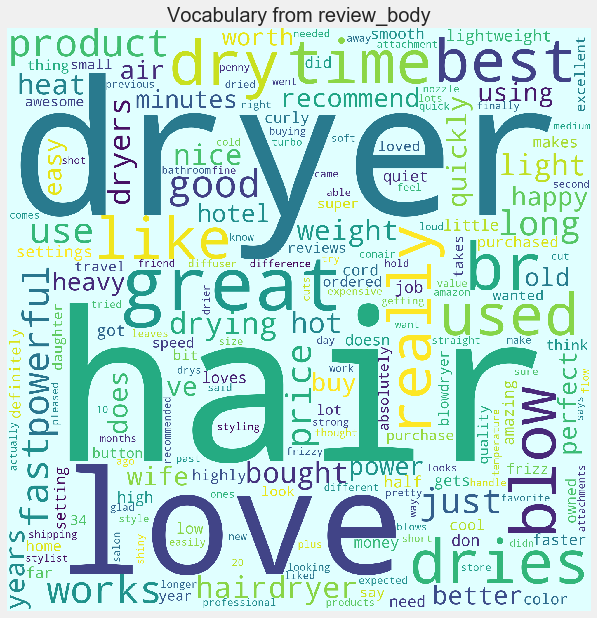

frequency for review_headline:          word       freq
0       dryer  67.081088
1       great  53.512339
2        love  52.009681
3        hair  47.066906
4        best  35.665169
5        good  27.419130
6     amazing  15.587559
7   hairdryer  15.494889
8     awesome  13.160069
9       price  12.349548
10       blow  12.248525
11      works  12.076602
12       nice  11.540225
13    product  10.481526
14      worth  10.114124
15   powerful   9.387533
16        buy   7.487282
17  excellent   6.595286
18     better   5.836903
19      value   5.823184


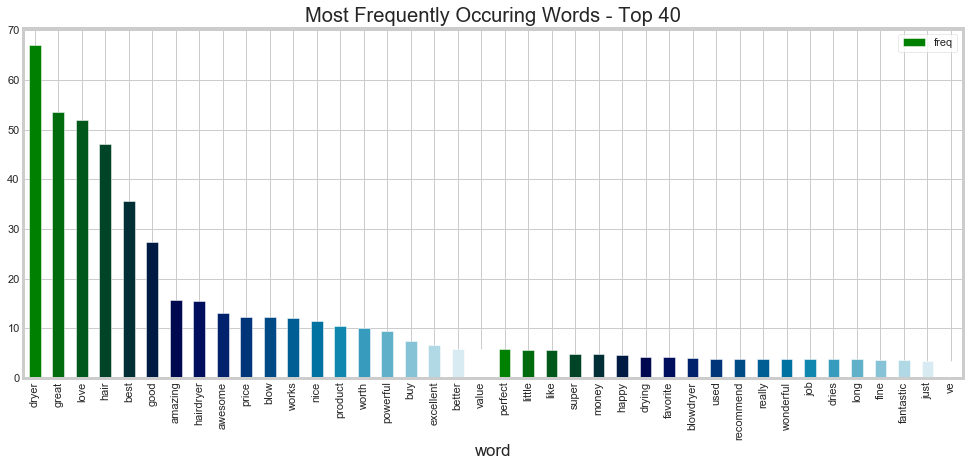

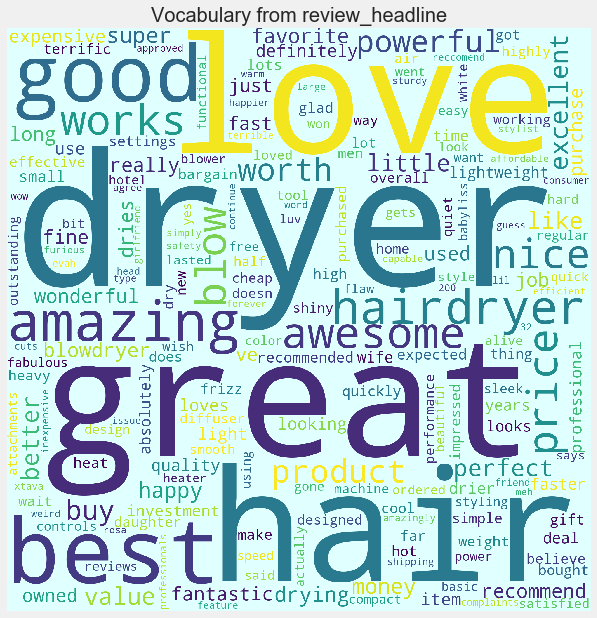

关键词为: ['hair', 'dryer', 'love', 'great', 'blow', 'best', 'used', 'like', 'product', 'good', 'works', 'powerful', 'price', 'hairdryer', 'drying', 'nice']
潜在成功种类产品评论数据其平均值为（热度）： 48.89473684210526
潜在成功种类产品评star_rating据其平均值为（热度）： 4.55005382131324
[945323010 959834931 977457747 768062995 380013605 466064538 453645026
 376749538 591023894 290876515 316756803 407404113 391944105 276205451
 646149518 593915883 646926938  16483457 486589264]
         CPS  review_num  verified_purchase_num
Year                                           
2013  100.00           1                      1
2014   76.92          13                     12
2015   86.67          15                     15


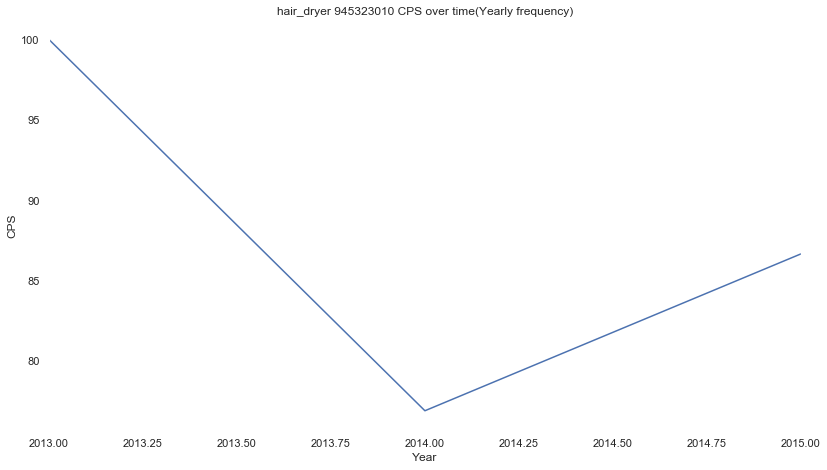

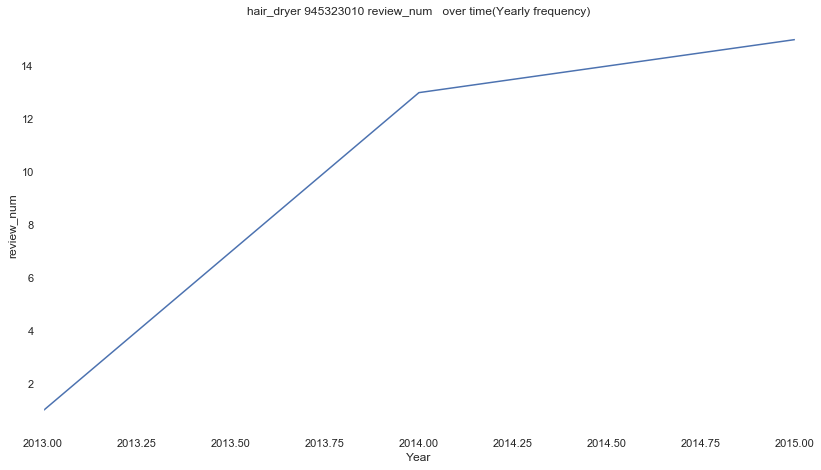

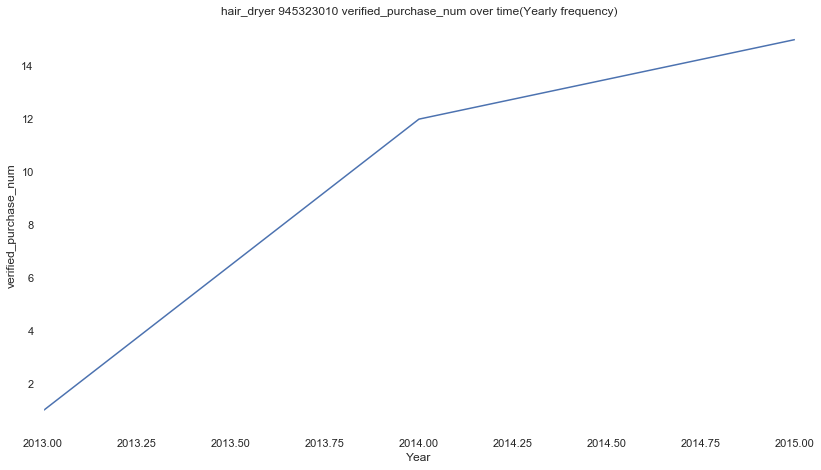

               CPS
Date              
2013-04-17  100.00
2014-12-30   76.92
2015-08-01   86.67


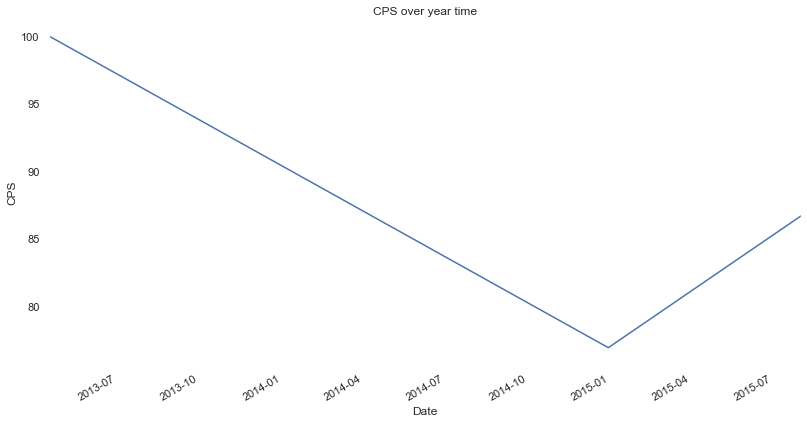

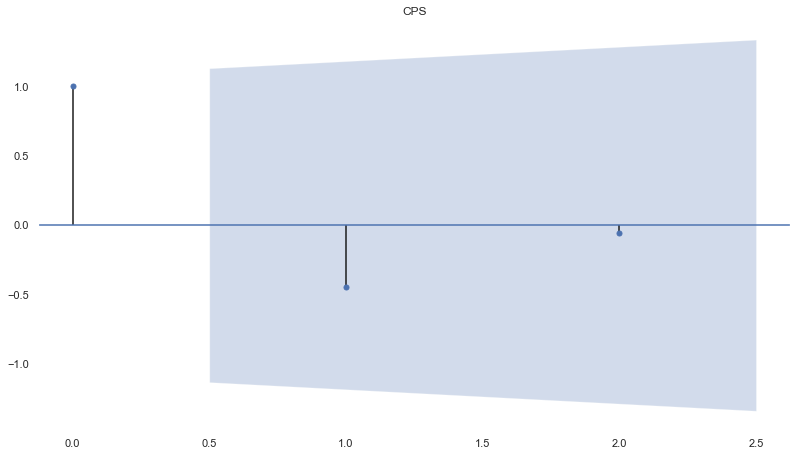

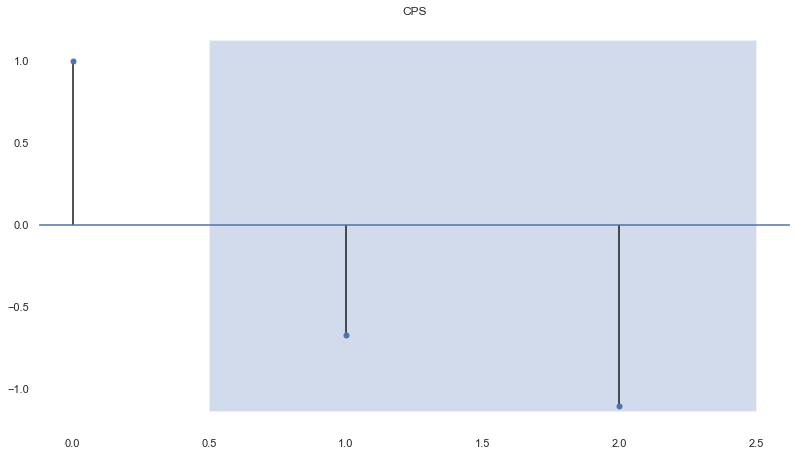

ValueError: sample size is too short to use selected regression component

In [337]:
most_import_factor(number_comments_data,20,"hair_dryer",True)

### 是否存在从众心理  研究 时间-评论个数问题 先研究不分种类

In [115]:
def average_day_month(every_group, year=None):
    # 删除分组后的hour列，形成的结果数据是日平均，所以不在需要小时数据
    every_group["review_num"] = every_group["review_num"].sum()
    return pd.DataFrame([every_group.iloc[0, :]], columns=every_group.columns)  

def vis_time_review_n(data,least_com=20,name=None):
#     data = data[data["product_parent"]==959834931]
    plt.rcParams['figure.figsize'] = (12, 7)
    plt.style.use('fivethirtyeight')
    sns.set_style("whitegrid")

    import math
    data["Year"] = 0
    data["Month"] = 0
    data["Day"] = 0
    data["Season"] = 0
    data["CPS"] = 0
    data["review_num"] = 1
    data["verified_purchase_num"] = 1
    for i,d in enumerate(data["review_date"]):
        m,d,y = data["review_date"][i].split("/")
        j = math.ceil(int(m)/3)
        data["Year"][i] = y
        data["Month"][i] = m
        data["Day"][i] = d
        data["Season"][i] = j
    # 按年进行分组
    group_by_year = data.groupby(["Year","star_rating"])
#     print(group_by_year.size().values)
    # 进行分组处理
    year_data = group_by_year.apply(average_day_month)
    print(year_data["review_num"])
    year_data["review_num"].to_csv("d_data.csv")
#     print(year_data)
#     print(data.index)
#     import plotly as py
#     import plotly.graph_objs as go

#     pyplt = py.offline.plot

#     trace0 = go.Scatter(
#     x=[1, 2, 3, 4, 5, 6, 7],
#     y=[8, 10, 12, 14, 16, 18, 20],
#     mode='markers',
#     marker=dict(
#         size=[10, 14, 16, 18, 20, 42, 64], #设置气泡大小

#     )
#     )

#     data = [trace0]
#     layout = go.Layout(
#        title = f'xxx',plot_bgcolor='#ffffff',paper_bgcolor='#ffffff')
#     fig = go.Figure(data = data,layout = layout)
#     py.iplot(fig)
#     year_data = year_data[year_data["review_num"]>least_com]
#     year_time_series = pd.DataFrame({"CPS":year_data["CPS"].values,
#                                     "review_num":year_data["review_num"].values,
#                                     "verified_purchase_num":year_data["verified_purchase_num"].values},index=year_data["Year"])
#     print(year_time_series)
#     plt.title(f'{name} CPS over time(Yearly frequency)')
#     plt.xlabel("datetime")
#     plt.ylabel("CPS")
#     year_time_series["CPS"].plot()
#     plt.show()
    
#     plt.title(f'{name} review_num   over time(Yearly frequency)')
#     plt.xlabel("datetime")
#     plt.ylabel("review_num")
#     year_time_series["review_num"].plot()
#     plt.show()
    
#     plt.title(f'{name} verified_purchase_num over time(Yearly frequency)')
#     plt.xlabel("datetime")
#     plt.ylabel("verified_purchase_num")
#     year_time_series["verified_purchase_num"].plot()
#     plt.show()
# #     print(data)
#     one_kind_data = pd.DataFrame({"star_rating":data["star_rating"],"review_rating":data["review_rating"],"reivew_star_rating":data["reivew_star_rating"],"Year":data["Year"]},index=data.index)
#     one_kind_data.sort_values("Year",inplace=True,ascending=True)
#     print(data)
#     plt.rcParams['figure.figsize'] = (12, 7)
#     plt.style.use('fivethirtyeight')
#     sns.set_style("whitegrid")
#     sns.boxplot(one_kind_data['Year'], one_kind_data['star_rating'], palette = 'Blues')
#     plt.title("star_rating vs Year")
# #     plt.savefig('6.png',dpi=200, bbox_inches='tight')
#     plt.show()
#     print(one_kind_data[one_kind_data["Year"]==2012])
#     print(one_kind_data[one_kind_data["Year"]==2013])
#     print(one_kind_data[one_kind_data["Year"]==2014])

In [116]:
vis_time_review_n(copy_data2,20,name="hair_dryer")

Year  star_rating                
2002  1            R2JQPUYU65C4QD       1
      3            R2XM83JYE2KDE2       1
      4            R33QQ6N5UIPSY1       1
      5            R3UIZ2BE5IJZA9       5
2003  3            R3MSSPW3QKYM4H       1
                                     ... 
2015  1            RTYQK30NMOCM6      233
      2            R1DZKVY1CJF3QP     119
      3            RYOOYLVIAHU2A      264
      4            RE36JAD5V53PO      486
      5            R9T1FE2ZX2X04     1891
Name: review_num, Length: 67, dtype: int64


In [ ]:
# def run():
#     number_comments_data = diff_credit(data_total[2],data_names[2])
#     most_import_factor(number_comments_data,20,data_names[2],False)
# run()

### 证明获得关键词和评分是强相关的

In [342]:
import re
import nltk
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.manifold import TSNE
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score,roc_auc_score
from sklearn.decomposition import PCA
from matplotlib import pyplot
sns.set(rc={'figure.facecolor':'white'})
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
def last_question(data,name=None):
#     comments = pd.concat([data['review_body']+""+data['review_headline']],axis=1)
    comments = pd.concat([data[data["product_parent"]==959834931]['review_body']+""+data[data["product_parent"]==959834931]['review_headline']],axis=1)
    comments.columns = ["review"]
    with open("unsupervise_train.txt",'w',encoding='utf8') as f:
        for i in range(0, comments.shape[0]):
            # 去除除了单词外的字符
            review = re.sub('[^a-zA-Z]', ' ', comments['review'][i])
            review = re.sub('br', ' ', review)
            review = re.sub('</s>', ' ', review)
            # 去除大小写的影响
            review = review.lower()
            review = review.split()
            # 词干提取（stemming）
            ps = nltk.WordNetLemmatizer()
            # 去除英语相应的助动词lemmatize
            review = [ps.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
#             review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
            review = ' '.join(review)
            f.write(review+"\n")
        f.close()
    model = fasttext.train_unsupervised("unsupervise_train.txt", model='cbow')
#     print(model.words)   # list of words in dictionary
#     print(len(model['good'])) # get the vector of the word 'king'

    wordvector=[]
    words = []
    for key in model.words:
        if key == "</s>":
            continue
        words.append(key)
        wordvector.append(model[key])
    
    #分类
    clf = AgglomerativeClustering(n_clusters=3,affinity= 'euclidean',linkage= 'ward')
    import scipy.cluster.hierarchy as shc
    dend = shc.dendrogram(shc.linkage((wordvector),method='ward'))
    print(words)
    plt.show()
    
    s = clf.fit(wordvector)
    #获取到所有词向量所属类别
    labels=clf.labels_

    #把是一类的放入到一个集合
    classCollects={}
    for i in range(len(words)):
        if labels[i] in classCollects.keys():
            classCollects[labels[i]].append(words[i])
        else:
            classCollects[labels[i]]=[words[i]]
    print(len(wordvector))
    print(len(wordvector[0]))
    
    tsne = TSNE(n_components=2,init='pca',verbose=1,random_state=777)
    embedd = tsne.fit_transform(wordvector)
    print(embedd.shape)
    #可视化
    plt.figure(figsize=(14,10))
    plt.scatter(embedd[:,0], embedd[:,1],c=labels,cmap='rainbow')
    
    for i in range(embedd.shape[0]):
        x = embedd[i][0]
        y = embedd[i][1]
        plt.text(x+1, y, words[i],bbox=dict(facecolor="pink", alpha=0.1),fontsize=20)
    plt.show()
    mood_words = []
    func_words = []
    for i,label in enumerate(labels):
        if label == 2:
            func_words.append(words[i])
        elif label == 0:
            mood_words.append(words[i])
    print(mood_words)
    print(func_words)
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    sid = SentimentIntensityAnalyzer()
    
    for word in mood_words:
        print(word+" score :"+str(sid.polarity_scores(word)["compound"]))
    print(func_words)
    print("""frequency for review_headline:          word       freq
0       dryer  67.081088
1       great  53.512339
2        love  52.009681
3        hair  47.066906
4        best  35.665169
5        good  27.419130
6     amazing  15.587559
7   hairdryer  15.494889
8     awesome  13.160069
9       price  12.349548
10       blow  12.248525
11      works  12.076602
12       nice  11.540225
13    product  10.481526
14      worth  10.114124
15   powerful   9.387533
16        buy   7.487282
17  excellent   6.595286
18     better   5.836903
19      value   5.823184""")
        

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\27215\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['dryer', 'hair', 'great', 'dry', 'blow', 'love', 'year', 'star', 'used', 'time', 'professional', 'one', 'long', 'powerful', 'work', 'product', 'back', 'drying', 'smooth', 'good', 'nice', 'worth', 'make', 'drier', 'fast', 'bought', 'hairdryer', 'purchase', 'come', 'power']


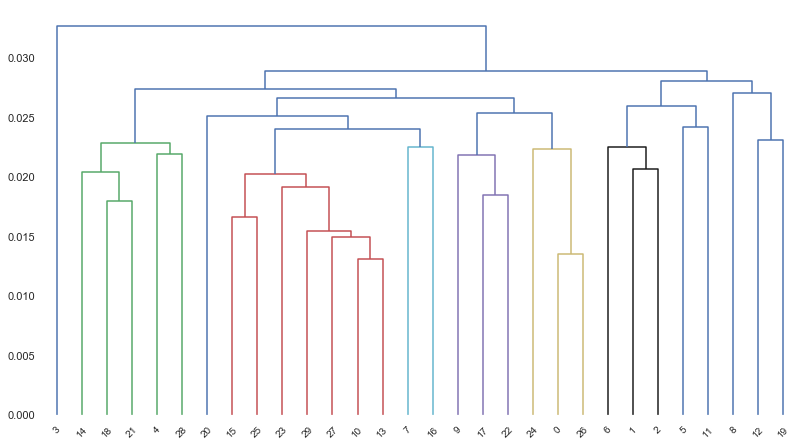

30
100
[t-SNE] Computing 29 nearest neighbors...
[t-SNE] Indexed 30 samples in 0.001s...
[t-SNE] Computed neighbors for 30 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 30 / 30
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.442417
[t-SNE] KL divergence after 1000 iterations: 0.647518
(30, 2)


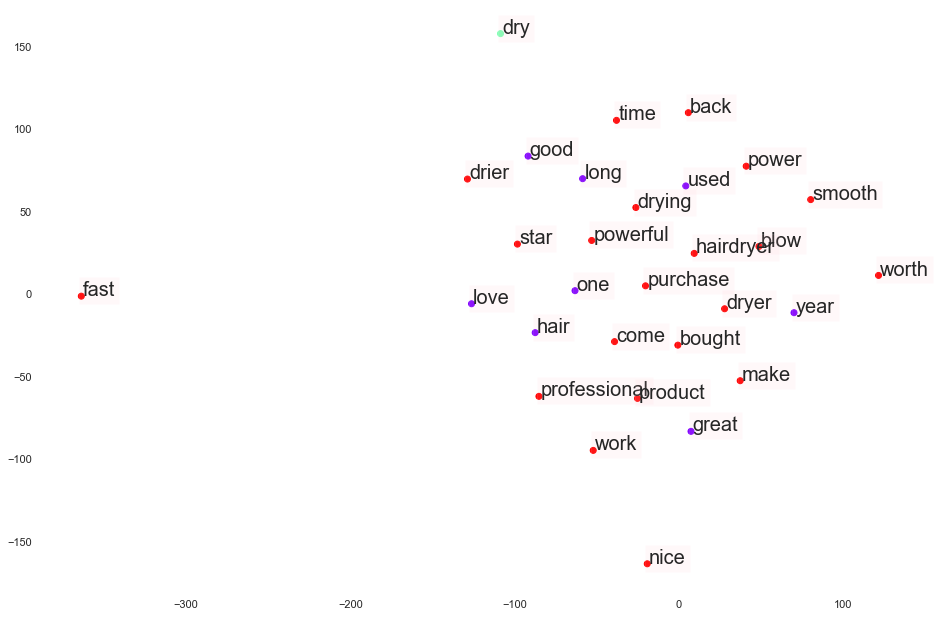

['hair', 'great', 'love', 'year', 'used', 'one', 'long', 'good']
['dryer', 'blow', 'star', 'time', 'professional', 'powerful', 'work', 'product', 'back', 'drying', 'smooth', 'nice', 'worth', 'make', 'drier', 'fast', 'bought', 'hairdryer', 'purchase', 'come', 'power']
hair score :0.0
great score :0.6249
love score :0.6369
year score :0.0
used score :0.0
one score :0.0
long score :0.0
good score :0.4404
['dryer', 'blow', 'star', 'time', 'professional', 'powerful', 'work', 'product', 'back', 'drying', 'smooth', 'nice', 'worth', 'make', 'drier', 'fast', 'bought', 'hairdryer', 'purchase', 'come', 'power']
frequency for review_headline:          word       freq
0       dryer  67.081088
1       great  53.512339
2        love  52.009681
3        hair  47.066906
4        best  35.665169
5        good  27.419130
6     amazing  15.587559
7   hairdryer  15.494889
8     awesome  13.160069
9       price  12.349548
10       blow  12.248525
11      works  12.076602
12       nice  11.540225
13    produ

In [343]:
last_question(data_total[0],data_names[0])